## ASSIGNMENT-2
Roll Numbers:

Names:

### Instructions
 * Fill in the roll numbers and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.

## G2O Motion Model 

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive nodes k and k+1.

## PART 2

### 1. ICP Alignment with LieTorch (5 marks)
Resources: https://github.com/princeton-vl/lietorch/tree/master

Perform ICP Alignment of 2 PointClouds using LieTorch. Similar to what was expected in Part 1, you will be given a random Transformation matrix from the getTransform function. You are expected to transform the Toothless Point Cloud by this transformation, add noise to both sets of points (original and transformed) and estimate both, the Transformation matrix and the original point cloud.

Visualize your results using open3d

In [67]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from lietorch import SE3, LieGroupParameter
import torch
import torch.optim as optim

device = torch.device('cuda')

In [68]:
def getTransform():
    euler_angles = torch.rand(3) * 2 * torch.pi 
    translation = torch.rand(3) * 100
    transformation_param = torch.cat((translation,euler_angles)).cuda()
    return SE3.exp(transformation_param)

def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    transformation_matrix = SE3_transform.matrix().to(device)
    rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]
    return transformed_points

def compute_loss(home_pcl, frame_pcl, transform):
    transformed = transform_point_cloud(home_pcl, transform)
    # transformed = transform.act(home_pcl)
    residual = frame_pcl - transformed
    loss = torch.norm(residual, dim=1).pow(2).mean()
    return loss

In [71]:
transform0 = getTransform()
transform1 = getTransform()

downsample = 1

pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_tensor = torch.tensor(np.array(pcl.points), dtype=torch.float32, device=device)

pcl0 = transform_point_cloud(pcl_tensor + (torch.randn_like(pcl_tensor) * 2), transform0, downsample)
pcl0_tensor = pcl0.requires_grad_(True)
pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0.detach().cpu().numpy()))
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])

pcl1 = transform_point_cloud(pcl_tensor + (torch.randn_like(pcl_tensor) * 2), transform1, downsample)
pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1.detach().cpu().numpy()))
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])
pcl1_tensor = pcl1.requires_grad_(True)

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcl0_geom)
vis.add_geometry(pcl1_geom)
vis.poll_events()
vis.update_renderer()

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        t = torch.randn(3).to(device)
        ea = torch.randn(3).to(device)
        self.vec = torch.nn.Parameter(ea)
        self.vec1 = torch.nn.Parameter(t)
        self.vec2 = torch.nn.Parameter(pcl0_tensor.clone())

    def forward(self):
        t = self.vec[:3]
        ea = self.vec1[:3]
        phi = torch.cat((t, ea))
        se3 = SE3.exp(phi)
        denoised_points = self.vec2
        return se3,denoised_points
    
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1)
errors = []

for i in range(1000):
    optimizer.zero_grad()
    y_hat,newpcl = model()
    loss = compute_loss(newpcl,pcl1_tensor,y_hat)
    loss.backward()
    optimizer.step()
    pcl0_geom.points = o3d.utility.Vector3dVector(transform_point_cloud(newpcl, y_hat).detach().cpu().numpy())
    vis.update_geometry(pcl0_geom)
    vis.poll_events()
    vis.update_renderer()
    error = loss.item()
    print(error)
    errors.append(error)

vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RMSE Error')
plt.title('RMSE Error over Iterations')
plt.grid()
plt.show()

14537.1611328125
16401.814453125
6432.64111328125
2399.7470703125
6361.44921875
7796.78662109375
6458.08837890625
3951.190673828125
1655.969970703125
1182.8917236328125
2651.16748046875
3683.47265625
3299.776611328125
2271.74267578125
1263.445556640625
668.2180786132812
838.6655883789062
1471.389404296875
1810.9249267578125
1562.9329833984375
1044.576416015625
600.1614990234375
351.5807800292969
428.54449462890625
773.1636352539062
974.4484252929688
803.3173217773438
482.14788818359375
270.1895751953125
216.8875732421875
315.0767517089844
487.9725341796875
538.590087890625
392.8653869628906
214.91033935546875
151.92564392089844
181.42501831054688
245.96119689941406
300.3218994140625
275.34588623046875
177.13369750976562
107.75450134277344
109.57295989990234
139.7680206298828
167.63717651367188
170.11851501464844
126.19315338134766
71.9359359741211
61.01359176635742
83.39604187011719
100.8228530883789
98.52769470214844
72.6588134765625
41.81898498535156
38.0402717590332
53.7555923461914

KeyboardInterrupt: 

In [72]:
vis.destroy_window()

### 2. ICP-SLAM with LieTorch (10 marks)

For this part, you will be given a set of `N` transformation matrices (Each relative to position 0). Add a random amount of noise to each of the `N` sets of points. Estimate the Transforms as well as the original point cloud using LieTorch.

Visualize your results using open3d

In [27]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from lietorch import SE3, LieGroupParameter
import torch
import torch.optim as optim
device = torch.device('cuda')

In [30]:
def getTransforms():
    # N = 2 + int(torch.rand(1) * 3)
    N = 2
    euler_angles = torch.rand(N, 3) * 2 * torch.pi 
    translation = torch.rand(N, 3) * 500
    transformation_params = torch.cat((translation, euler_angles), dim=1).cuda()
    return SE3.exp(transformation_params)

def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    transformation_matrix = SE3_transform.matrix().to(device)
    rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]
    return transformed_points

def compute_loss(home_pcl, frame_pcls, transforms):
    total_loss = 0.0
    n_pcls = len(frame_pcls)
    for i in range(n_pcls):
        transformed = transform_point_cloud(home_pcl, transforms[i])
        residual = frame_pcls[i] - transformed
        loss = torch.norm(residual, dim=1).pow(2).mean()
        total_loss += loss
    # total_loss /= n_pcls
    return total_loss

In [37]:
transforms = getTransforms()
no_of_pcls = transforms.shape[0]
print("N:",no_of_pcls)

downsample = 0.8

pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_tensor = torch.tensor(np.array(pcl.points), dtype=torch.float32, device=device)

pcls_transformed = []
pcl_geoms = []

for i in range(no_of_pcls):
    pcl_i = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor) * 1, transforms[i], downsample)
    pcl_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl_i.detach().cpu().numpy()))
    pcl_geom.paint_uniform_color([0.0, 0.0, 1.0])
    pcl_geoms.append(pcl_geom)
    pcls_transformed.append(pcl_i)
pcl_geoms[0].paint_uniform_color([1.0, 0.0, 0.0])

pcls_transformed_tensor = torch.stack(pcls_transformed, dim=0).requires_grad_(True)

vis = o3d.visualization.Visualizer()
vis.create_window()
for pcl_geom in pcl_geoms:
    vis.add_geometry(pcl_geom)

vis.poll_events()
vis.update_renderer()
# vis.run()
# vis.destroy_window()

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        t = torch.randn(no_of_pcls-1,3).to(device)
        ea = torch.randn(no_of_pcls-1,3).to(device)
        self.vec = torch.nn.Parameter(ea)
        self.vec1 = torch.nn.Parameter(t)
        self.vec2 = torch.nn.Parameter(pcls_transformed_tensor[0].clone())

    def forward(self):
        t = self.vec
        ea = self.vec1
        phi = torch.cat((t, ea))
        se3 = SE3.exp(phi)
        denoised_points = self.vec2
        return se3,denoised_points

model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1)
errors = []

for i in range(1000):
    optimizer.zero_grad()
    y_hat,newpcl = model()
    loss = compute_loss(newpcl,pcls_transformed[1:],y_hat)
    loss.backward()
    optimizer.step()
    pcl_geoms[0].points = o3d.utility.Vector3dVector(transform_point_cloud(newpcl, y_hat[0]).detach().cpu().numpy())
    # vis.update_geometry(pcl_geoms[0])
    # for j in range(no_of_pcls-1):
    #     pcl_geoms[j+1].points = o3d.utility.Vector3dVector(transform_point_cloud(pcls_transformed_tensor[j+1], y_hat[j+1].inv()).detach().cpu().numpy())
    for pcl_geom in pcl_geoms:
        vis.add_geometry(pcl_geom)
    
    vis.poll_events()
    vis.update_renderer()
    error = loss.item()
    print(error)
    errors.append(error)

vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RMSE Error')
plt.title('RMSE Error over Iterations')
plt.grid()
plt.show()

N: 2
518274.0625
142339.25
408255.28125
287740.3125
75850.7578125
162418.21875
250407.8125
191465.578125
88328.109375
85980.828125
151697.5
162600.046875
110209.0078125
67788.0078125
84591.3203125
119054.7265625
116771.046875
81684.9453125
59298.7578125
73917.8671875
93625.1640625
86537.40625
63518.1171875
53892.3828125
63231.859375
71668.703125
66621.421875
54242.7890625
46731.6328125
48109.80859375
52070.09375
51355.0625
45718.57421875
40110.26953125
37981.9765625
38642.5625
39716.59765625
39740.98828125
38615.9609375
36940.2109375
35366.640625
34295.5390625
33820.2109375
33791.51171875
33926.44140625
33931.5625
33613.09765625
32935.65234375
32005.4921875
30995.767578125
30061.19921875
29283.486328125
28659.044921875
28117.912109375
27559.515625
26896.47265625
26098.83203125
25222.32421875
24395.326171875
23748.2890625
23313.666015625
22981.25
22582.126953125
22046.98828125
21470.06640625
20997.75390625
20669.21484375
20385.99609375
20025.8203125
19564.3046875
19082.5703125
18667.980

KeyboardInterrupt: 

In [38]:
vis.destroy_window()

Failed to converge


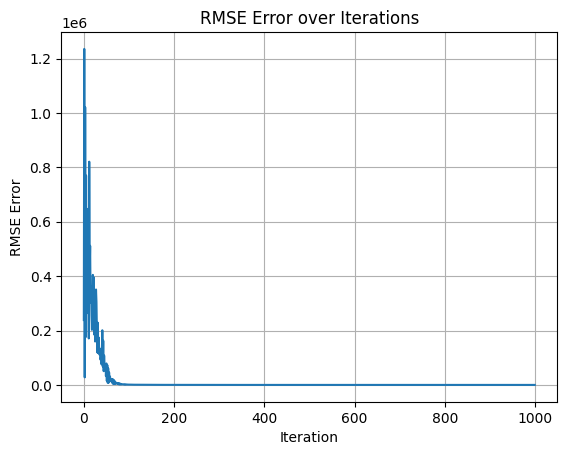

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Make sure to set the device
device = torch.device('cuda')

def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    
    transformation_matrix = SE3_transform.matrix().to(device)
    
    if transformation_matrix.dim() == 2:
        # Single transformation
        rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
        transformed_points = rotated_points + transformation_matrix[:3, 3]
    elif transformation_matrix.dim() == 3:
        # Batch of transformations
        rotated_points = torch.matmul(point_cloud.unsqueeze(0), transformation_matrix[:, :3, :3].transpose(1, 2))
        transformed_points = rotated_points + transformation_matrix[:, :3, 3].unsqueeze(1)
    else:
        raise ValueError("Transformation matrix must be either 2D or 3D.")
    
    return transformed_points


# Compute loss between N transformed point clouds and the reference point cloud
def compute_loss(pcl0, pcls_transformed):
    residuals = pcls_transformed - pcl0.unsqueeze(0)
    loss = torch.norm(residuals, dim=-1).pow(2).mean()
    return loss

# Load point cloud and convert to tensor
pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_tensor = torch.tensor(np.array(pcl.points), dtype=torch.float32, device=device)

# Define the number of point clouds to be transformed
N = 5
downsample = 0.05

# Get transformations for N point clouds
transforms = getTransforms(N)

# Generate N noisy versions of the point cloud and transform them
pcl0 = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor) * 1, transforms[0], downsample)
pcl0_tensor = pcl0.requires_grad_(True)
pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0.detach().cpu().numpy()))
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])

pcls_transformed = []
pcl_geoms = []

for i in range(N):
    pcl_i = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor) * 1, transforms[i], downsample)
    pcl_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl_i.detach().cpu().numpy()))
    pcl_geom.paint_uniform_color([0.0, 0.0, 1.0])
    pcl_geoms.append(pcl_geom)
    pcls_transformed.append(pcl_i)

pcls_transformed_tensor = torch.stack(pcls_transformed, dim=0).requires_grad_(True)

# Setup Open3D visualization
frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
frame_torch = torch.tensor(np.array(frame0.vertices), dtype=torch.float32, device=device)
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcl0_geom)
for pcl_geom in pcl_geoms:
    vis.add_geometry(pcl_geom)
vis.add_geometry(frame0)
vis.add_geometry(frame1)
vis.poll_events()
vis.update_renderer()

# Define the model for transforming N point clouds
class Model(torch.nn.Module):
    def __init__(self, N):
        super(Model, self).__init__()
        q = torch.randn(N, 4, device=device)
        q = q / q.norm(dim=1, keepdim=True)
        t = torch.randn(N, 3, device=device)
        self.vec = torch.nn.Parameter(torch.cat((t, q), dim=1))

    def forward(self, input):
        t = self.vec[:, :3]
        q = self.vec[:, 3:]
        q = q / q.norm(dim=1, keepdim=True)
        se3_transform = SE3.InitFromVec(self.vec)
        return transform_point_cloud(input, se3_transform)

model = Model(N).to(device)
optimizer = optim.SGD(model.parameters(), 4e-0, momentum=0.9, weight_decay=0)

errors = []

# Optimization loop
for i in range(1000):
    optimizer.zero_grad()
    y_hat = model(pcls_transformed_tensor)
    loss = compute_loss(pcl0_tensor, y_hat)
    loss.backward()
    optimizer.step()

    opti_transform = SE3.InitFromVec(model.vec)

    for j in range(N):
        pcl_geoms[j].points = o3d.utility.Vector3dVector(transform_point_cloud(pcls_transformed_tensor[j], opti_transform[j]).detach().cpu().numpy())
    pcl0_geom.points = o3d.utility.Vector3dVector(pcl0_tensor.detach().cpu().numpy())
    frame1.vertices = o3d.utility.Vector3dVector(transform_point_cloud(frame_torch, opti_transform[0]).detach().cpu().numpy())
    vis.update_geometry(pcl0_geom)
    for pcl_geom in pcl_geoms:
        vis.update_geometry(pcl_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    error = loss.item()
    # print(error)
    errors.append(error)
    
    if error < 3e0:
        pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
        for pcl_geom in pcl_geoms:
            pcl_geom.paint_uniform_color([0.0, 1.0, 0.0])
        vis.update_geometry(pcl0_geom)
        for pcl_geom in pcl_geoms:
            vis.update_geometry(pcl_geom)
        print(f"Converged in {i} iterations with {error:.4f} error.")
        break

if error > 3e0:
    print("Failed to converge")

vis.run()
vis.destroy_window()

# Plot errors
plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RMSE Error')
plt.title('RMSE Error over Iterations')
plt.grid()
plt.show()


In [ ]:
vis.destroy_window()